<a href="https://colab.research.google.com/github/J-DR1/MastersThesis/blob/main/2_Fraud_models_experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

---



In [ ]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.models.hbos import HBOS
  from pyod.models.abod import ABOD
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn
##Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import preprocessing

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Functions 

---



In [ ]:
#Functions 
#Train-test splits
def time_split_train_test(full_dataframe):
    train_set = full_dataframe.iloc[:200000]
    train_X = train_set.drop('Class', axis = 1) 
    train_y = train_set['Class']
    
    test_set = full_dataframe.iloc[-70000:]
    test_X = test_set.drop('Class', axis = 1)
    test_y = test_set['Class']
    return train_X, test_X, train_y, test_y

#Prints true contamination rate
def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)

#Fitting and predictions 
def get_prediction(classifier, train_X, test_X, train_y, test_y, model_name =''):
  
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    score = clf.decision_function(test_X)

    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, train_y, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, test_y, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly'] ))
    #print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
    print("\n", model_name, "f1-score", f1_score(test_y, pred))

    #Plots confusion matrix
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Anomaly','Predicted Normal'],
                yticklabels = ['Actual Anomaly','Actual Normal'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    #Plots ROC Curve
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #Plots PR Curve
    prec, recall, _ = precision_recall_curve(test_y, score,
                                         pos_label = clf.labels_[1])
    prec_ave = average_precision_score(test_y, score)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision= prec_ave, estimator_name= model_name).plot()

#Functions for iso-tree package (same steps as above)
def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, model_name =''):

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    score = clf.decision_function(test_X)

    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, temp_pred))
    print("\n", model_name, "f1-score", f1_score(test_y, temp_pred))

    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, temp_pred),
                xticklabels = ['Predicted Anomaly','Predicted Normal'],
                yticklabels = ['Actual Anomaly','Actual Normal'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    prec, recall, _ = precision_recall_curve(test_y, score,
                                         pos_label = clf.labels_[1])
    prec_ave = average_precision_score(test_y, score)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision= prec_ave, estimator_name= model_name).plot()

#Import & Standardization of Fraud

---



In [ ]:
#Dataset
fraud = pd.read_csv("creditcard.csv")
fraud.head(5) 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


#Train-Test Split & Oversampling

---



In [ ]:
train_X, test_X, train_y, test_y = time_split_train_test(fraud)

In [ ]:
#Standardization
scaler = RobustScaler()

train_X['normAmount'] = scaler.fit_transform(train_X['Amount'].values.reshape(-1, 1))
train_X['normTime'] = scaler.fit_transform(train_X['Time'].values.reshape(-1, 1))

test_X['normAmount'] = scaler.transform(test_X['Amount'].values.reshape(-1, 1))
test_X['normTime'] = scaler.transform(test_X['Time'].values.reshape(-1, 1))

train_X_std = train_X.drop(['Amount'],axis=1)
train_X_std = train_X.drop(['Time'],axis=1)
test_X_std = test_X.drop(['Amount'], axis=1)
test_X_std = test_X.drop(['Time'], axis=1)

train_X = train_X.drop(['normAmount'],axis=1)
train_X = train_X.drop(['normTime'],axis=1)
test_X = test_X.drop(['normAmount'], axis=1)
test_X = test_X.drop(['normTime'], axis=1)



### Subsampling

In [ ]:
count_class_0 = 46500

In [ ]:
train_X_us, train_y_us= NearMiss(sampling_strategy={0: count_class_0}).fit_resample(train_X, train_y)
train_X_std_us, train_y_std_us= NearMiss(sampling_strategy={0: count_class_0}).fit_resample(train_X_std, train_y)

In [ ]:
count_class_1 = 3500

train_X, train_y= SMOTE(sampling_strategy={1: count_class_1}).fit_resample(train_X_us, train_y_us)
train_X_std, train_y_std= SMOTE(sampling_strategy={1: count_class_1}).fit_resample(train_X_std_us, train_y_std_us)

In [ ]:
def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.07
Percentage Test Set Contamination:      0.0009285714285714286


### Oversampling

In [ ]:
#Oversampling with Smote
train_X_resampled, train_y_resampled= SMOTE(ratio = 'minority').fit_sample(train_X, train_y)
train_X_std_resampled, train_y_std_resampled= SMOTE(ratio= 'minority').fit_sample(train_X_std, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.07
Percentage Test Set Contamination:      0.0009285714285714286


# Results of MCC tuning

## IForest

---



On Training Data:
IForest ROC:0.9271, precision @ rank n:0.8405

On Test Data:
IForest ROC:0.803, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     69908
     Anomaly       0.00      0.00      0.00        92

    accuracy                           0.99     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      0.99      0.99     70000


 IForest Matthews Correlation Coefficient -0.0033702414993158508

 IForest f1-score 0.0


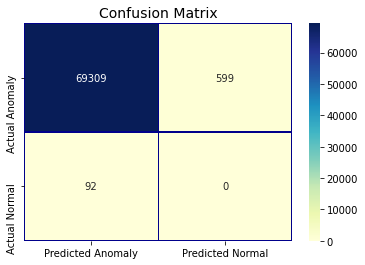

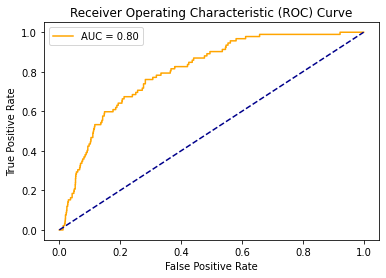

In [ ]:
#oversampled
#standardized
get_prediction(IForest(n_estimators = 125, max_samples = 'auto', contamination = 0.09), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.8136, precision @ rank n:0.7294

On Test Data:
IForest ROC:0.7884, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.00      0.00      0.00        92

    accuracy                           1.00     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      1.00      1.00     70000


 IForest Matthews Correlation Coefficient -0.002036931070358709

 IForest f1-score 0.0


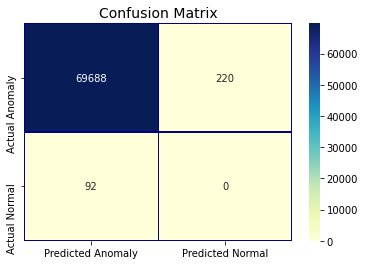

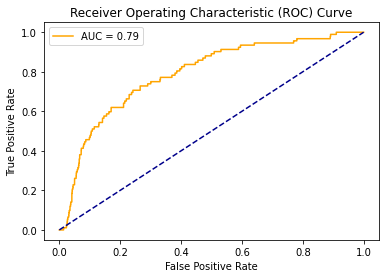

In [ ]:
#oversampled
#not standardized
get_prediction(IForest(n_estimators = 50, max_samples = 128, contamination = 0.05), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.9587, precision @ rank n:0.7694

On Test Data:
IForest ROC:0.9364, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     69908
     Anomaly       0.05      0.50      0.10        92

    accuracy                           0.99     70000
   macro avg       0.53      0.74      0.55     70000
weighted avg       1.00      0.99      0.99     70000


 IForest Matthews Correlation Coefficient 0.16149189601564534

 IForest f1-score 0.0975609756097561


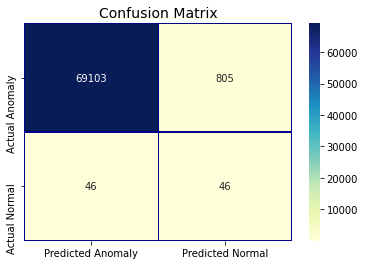

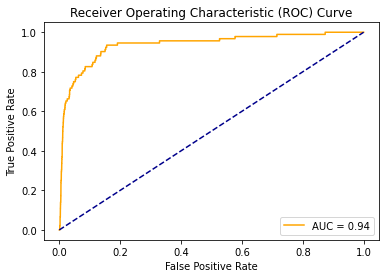

In [ ]:
#Not oversampled
#Not standardized
get_prediction(IForest(n_estimators = 75, max_samples = 128, contamination = 0.05), 
               train_X, test_X, train_y, test_y, 'IForest')

On Training Data:
IForest ROC:0.9627, precision @ rank n:0.8671

On Test Data:
IForest ROC:0.902, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.00      0.00      0.00        92

    accuracy                           1.00     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      1.00      1.00     70000


 IForest Matthews Correlation Coefficient -0.00019391109420497727

 IForest f1-score 0.0


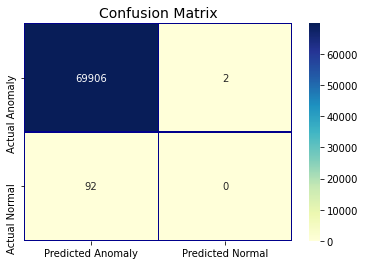

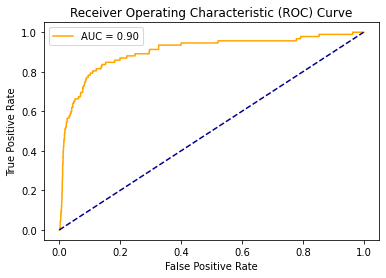

In [ ]:
#Not oversampled
#Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 'auto', contamination = 0.01), 
               train_X_std, test_X_std, train_y_std, test_y, 'IForest')

##OCSVM

---



In [ ]:
#Not Oversampled
#Standardized
get_prediction(OCSVM(gamma = 0.0001, contamination= 0.01, kernel = 'rbf'),
               train_X_std, test_X_std, train_y_std, test_y, 'OCSVM')

In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'OCSVM')

In [ ]:
#Not Oversampled
#Not standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.4854, precision @ rank n:0.4851

On Test Data:
LOF ROC:0.6461, precision @ rank n:0.0326

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.34      0.51     69908
     Anomaly       0.00      0.91      0.00        92

    accuracy                           0.34     70000
   macro avg       0.50      0.63      0.25     70000
weighted avg       1.00      0.34      0.51     70000


 LOF Matthews Correlation Coefficient 0.019275130741420843

 LOF f1-score 0.0036201435128321163


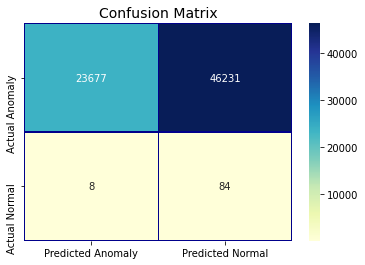

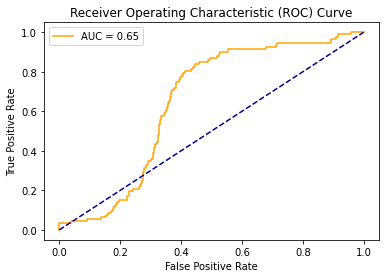

In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.09, algorithm='auto', metric= 'cosine'), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.3135, precision @ rank n:0.3435

On Test Data:
LOF ROC:0.8461, precision @ rank n:0.163

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.27      0.03      0.06        92

    accuracy                           1.00     70000
   macro avg       0.64      0.52      0.53     70000
weighted avg       1.00      1.00      1.00     70000


 LOF Matthews Correlation Coefficient 0.09391884879703334

 LOF f1-score 0.05825242718446602


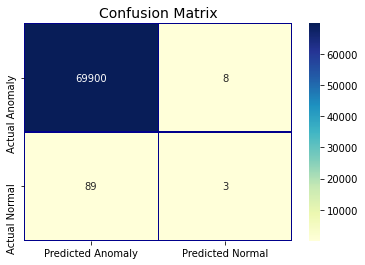

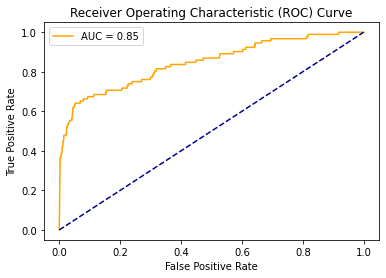

In [ ]:
#Oversampled
#Not standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.01, algorithm='auto', metric= 'cosine'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.8706, precision @ rank n:0.3806

On Test Data:
LOF ROC:0.9135, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.00      0.00      0.00        92

    accuracy                           1.00     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      1.00      1.00     70000


 LOF Matthews Correlation Coefficient -0.0018213124088576373

 LOF f1-score 0.0


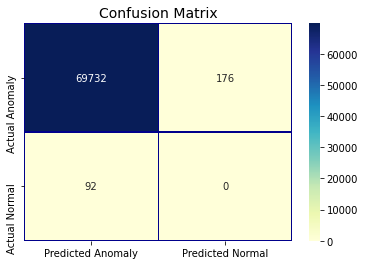

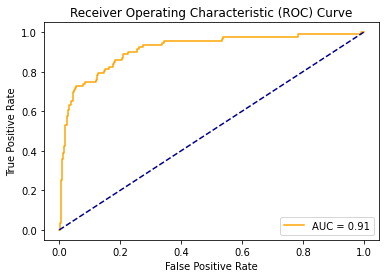

In [ ]:
#Not oversampled
#Not standardized
get_prediction(LOF(n_neighbors=700, contamination= 0.05, algorithm='auto', metric= 'cosine'), 
               train_X, test_X, train_y, test_y, 'LOF')

On Training Data:
LOF ROC:0.3988, precision @ rank n:0.0894

On Test Data:
LOF ROC:0.295, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.68      0.81     69908
     Anomaly       0.00      0.09      0.00        92

    accuracy                           0.68     70000
   macro avg       0.50      0.38      0.40     70000
weighted avg       1.00      0.68      0.81     70000


 LOF Matthews Correlation Coefficient -0.018185205003474838

 LOF f1-score 0.0007091884224990027


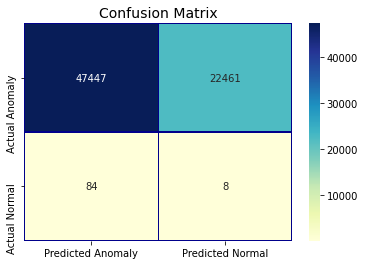

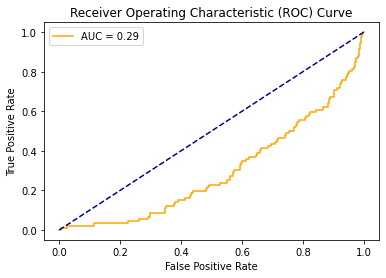

In [ ]:
#Not oversampled
#Standardized
get_prediction(LOF(n_neighbors=100, contamination= 0.01, algorithm='auto', metric= 'cityblock'), 
               train_X_std, test_X_std, train_y_std, test_y, 'LOF')

## CBLOF

---



On Training Data:
CBLOF ROC:0.9645, precision @ rank n:0.9257

On Test Data:
CBLOF ROC:0.653, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.93      0.96     69908
     Anomaly       0.00      0.14      0.01        92

    accuracy                           0.93     70000
   macro avg       0.50      0.53      0.48     70000
weighted avg       1.00      0.93      0.96     70000


 CBLOF Matthews Correlation Coefficient 0.009746648879281075

 CBLOF f1-score 0.005073170731707317


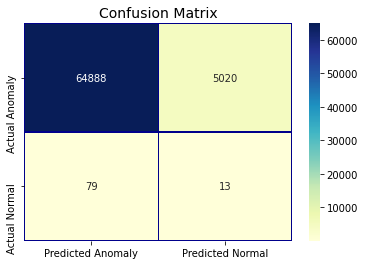

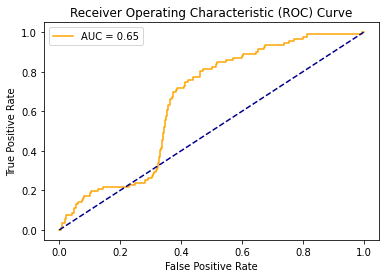

In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.07, n_clusters= 15, alpha= 0.8, beta= 15, random_state= 42), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.5254, precision @ rank n:0.485

On Test Data:
CBLOF ROC:0.4402, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 CBLOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 CBLOF f1-score 0.0026251212691890654


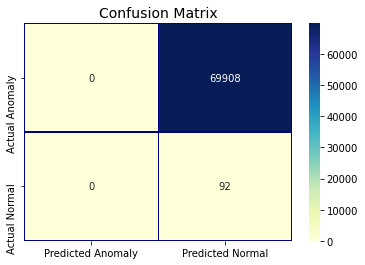

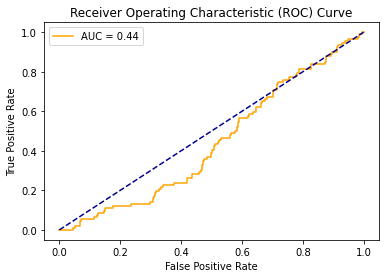

In [ ]:
#Oversampled
#Not standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 25, alpha= 0.9, beta= 20, random_state= 42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.6484, precision @ rank n:0.1703

On Test Data:
CBLOF ROC:0.4402, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 CBLOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 CBLOF f1-score 0.0026251212691890654


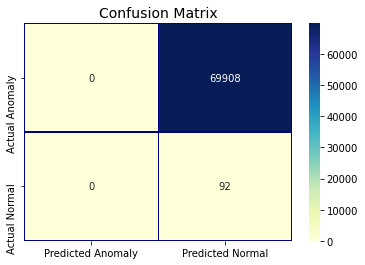

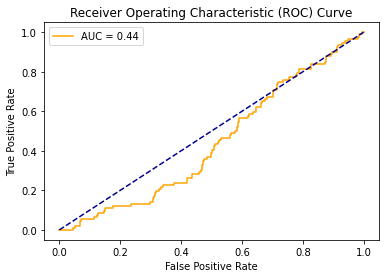

In [ ]:
#Not oversampled
#Not standardized
get_prediction(CBLOF(contamination= 0.09, n_clusters= 25, alpha= 0.8, beta= 25, random_state= 42), 
               train_X, test_X, train_y, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.9765, precision @ rank n:0.9309

On Test Data:
CBLOF ROC:0.697, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.77      0.87     69908
     Anomaly       0.00      0.27      0.00        92

    accuracy                           0.77     70000
   macro avg       0.50      0.52      0.44     70000
weighted avg       1.00      0.77      0.87     70000


 CBLOF Matthews Correlation Coefficient 0.0036609730038205455

 CBLOF f1-score 0.0030971258671952428


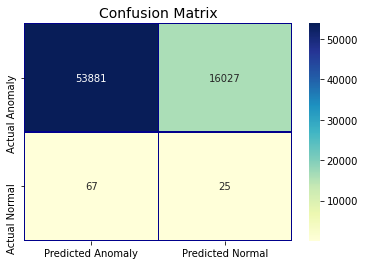

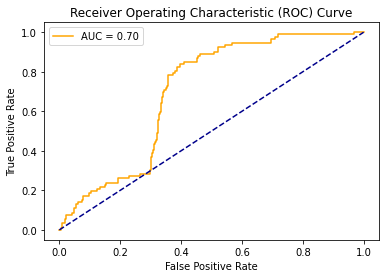

In [ ]:
#Not oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.03, n_clusters= 20, alpha= 0.9, beta= 25, random_state= 42), 
               train_X_std, test_X_std, train_y_std, test_y, 'CBLOF')

## KNN

---



On Training Data:
KNN ROC:0.3449, precision @ rank n:0.3713

On Test Data:
KNN ROC:0.5798, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.44      0.61     69908
     Anomaly       0.00      0.73      0.00        92

    accuracy                           0.44     70000
   macro avg       0.50      0.58      0.31     70000
weighted avg       1.00      0.44      0.61     70000


 KNN Matthews Correlation Coefficient 0.012297833604784878

 KNN f1-score 0.003410450230332646


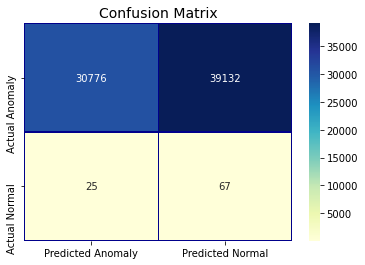

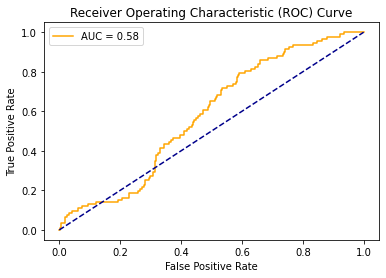

In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 100, method= 'median', algorithm='auto',contamination= 0.03), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.2055, precision @ rank n:0.2611

On Test Data:
KNN ROC:0.4401, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 KNN Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 KNN f1-score 0.0026251212691890654


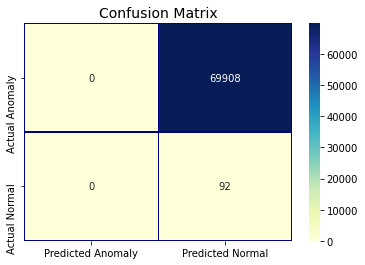

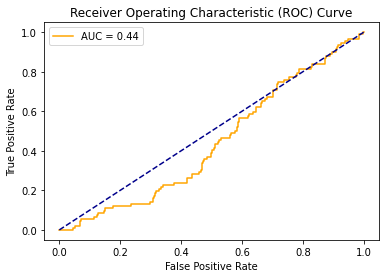

In [ ]:
#Oversampled
#Not standardized
get_prediction(KNN(n_neighbors= 5, method= 'mean', algorithm='auto',contamination= 0.03), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.7331, precision @ rank n:0.3317

On Test Data:
KNN ROC:0.4402, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 KNN Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 KNN f1-score 0.0026251212691890654


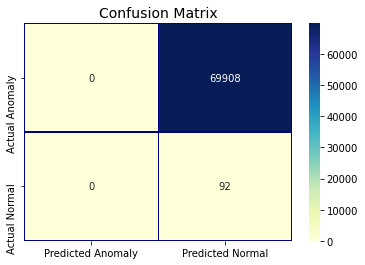

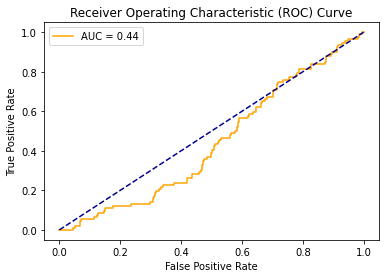

In [ ]:
#Not oversampled
#Not Standardized
get_prediction(KNN(n_neighbors= 500, method= 'median', algorithm='auto',contamination= 0.07), 
               train_X, test_X, train_y, test_y, 'KNN')

On Training Data:
KNN ROC:0.978, precision @ rank n:0.8934

On Test Data:
KNN ROC:0.6319, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     69908
     Anomaly       0.00      0.12      0.00        92

    accuracy                           0.89     70000
   macro avg       0.50      0.50      0.47     70000
weighted avg       1.00      0.89      0.94     70000


 KNN Matthews Correlation Coefficient 0.000660248970938498

 KNN f1-score 0.002730544867816805


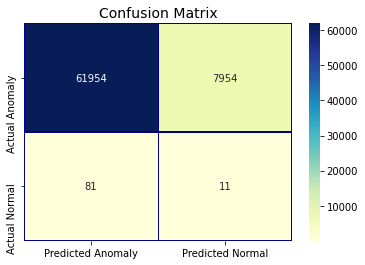

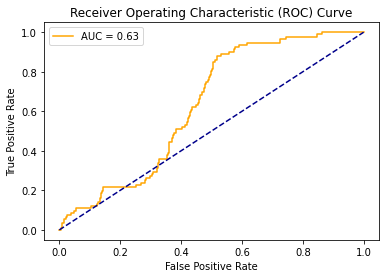

In [ ]:
#Not oversampled
#Standardized n = 100
get_prediction(KNN(n_neighbors= 100, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X_std, test_X_std, train_y_std, test_y, 'KNN')

## SCiForest-Isotree

---




 SCiForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     69908
           1       0.00      0.11      0.01        92

    accuracy                           0.96     70000
   macro avg       0.50      0.54      0.49     70000
weighted avg       1.00      0.96      0.98     70000


 SCiForest  Confusion Matrix: 
 [[67255  2653]
 [   82    10]]

 SCiForest Matthews Correlation Coefficient 0.013398167319095487

 SCiForest f1-score 0.007259528130671506


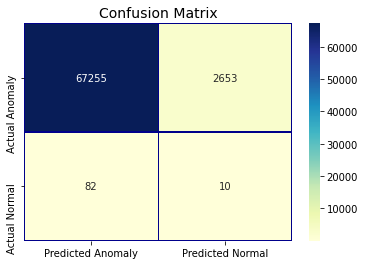

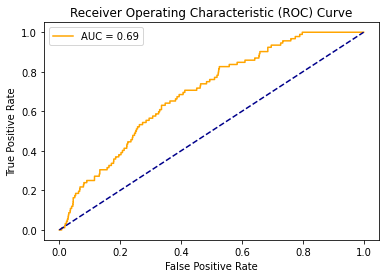

In [ ]:
#Oversampled
#Standardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'SCiForest')


 SCiForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     69908
           1       0.00      0.05      0.01        92

    accuracy                           0.98     70000
   macro avg       0.50      0.52      0.50     70000
weighted avg       1.00      0.98      0.99     70000


 SCiForest  Confusion Matrix: 
 [[68483  1425]
 [   87     5]]

 SCiForest Matthews Correlation Coefficient 0.008698406948397746

 SCiForest f1-score 0.006570302233902759


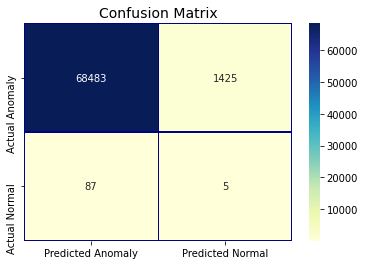

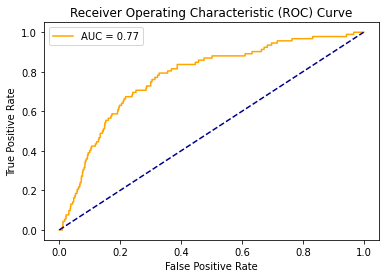

In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SCiForest')


 SCiForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     69908
           1       0.01      0.76      0.03        92

    accuracy                           0.93     70000
   macro avg       0.51      0.85      0.50     70000
weighted avg       1.00      0.93      0.96     70000


 SCiForest  Confusion Matrix: 
 [[64961  4947]
 [   22    70]]

 SCiForest Matthews Correlation Coefficient 0.09692831888625392

 SCiForest f1-score 0.027402622822470152


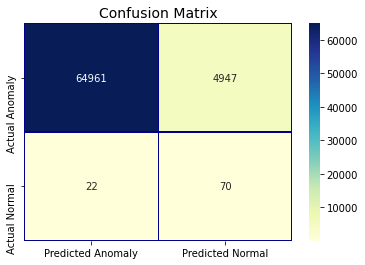

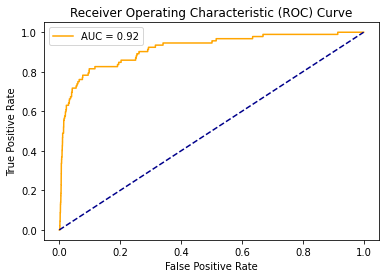

In [ ]:
#Not Oversampled
#not standardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SCiForest')


 SCiForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93     69908
           1       0.01      0.79      0.02        92

    accuracy                           0.87     70000
   macro avg       0.50      0.83      0.47     70000
weighted avg       1.00      0.87      0.93     70000


 SCiForest  Confusion Matrix: 
 [[60832  9076]
 [   19    73]]

 SCiForest Matthews Correlation Coefficient 0.0713306360168558

 SCiForest f1-score 0.015799155935504815


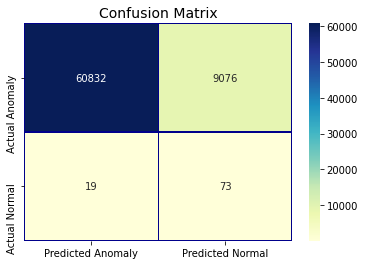

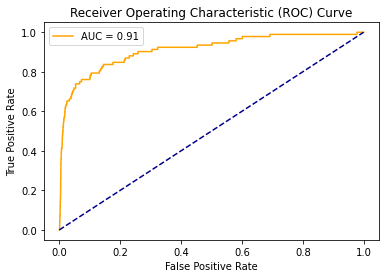

AttributeError: ignored

In [ ]:
#Not Oversampled
#Standardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees= 50, penalize_range=False, missing_action = "fail"), 
                   train_X_std, test_X_std, train_y, test_y, 'SCiForest')

## HBOS (Not included in the experiments)

On Training Data:
HBOS ROC:0.9567, precision @ rank n:0.8972

On Test Data:
HBOS ROC:0.8789, precision @ rank n:0.0

 HBOS  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.00      0.00      0.00        92

    accuracy                           1.00     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      1.00      1.00     70000


 HBOS Matthews Correlation Coefficient -0.0019124274266032583

 HBOS f1-score 0.0


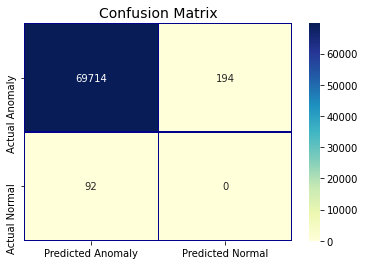

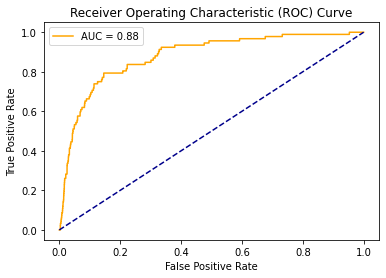

In [ ]:
get_prediction(HBOS(n_bins=20, alpha=0.1, tol=0.5, contamination=0.05), train_X_std_resampled,
               test_X_std, train_y_std_resampled, test_y, model_name = 'HBOS')

On Training Data:
HBOS ROC:0.9278, precision @ rank n:0.8608

On Test Data:
HBOS ROC:0.8812, precision @ rank n:0.0

 HBOS  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.00      0.00      0.00        92

    accuracy                           1.00     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      1.00      1.00     70000


 HBOS Matthews Correlation Coefficient -0.0016584839113102628

 HBOS f1-score 0.0


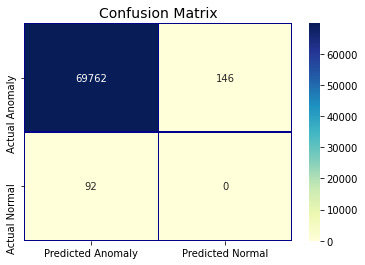

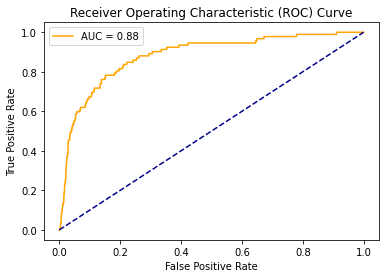

In [ ]:
get_prediction(HBOS(n_bins=80, alpha=0.1, tol=0.5, contamination=0.07), train_X_resampled,
               test_X, train_y_resampled, test_y, model_name = 'HBOS')

HBOS ROC:0.9205, precision @ rank n:0.0109

 HBOS  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     69908
     Anomaly       0.05      0.43      0.09        92

    accuracy                           0.99     70000
   macro avg       0.52      0.71      0.54     70000
weighted avg       1.00      0.99      0.99     70000


 HBOS Matthews Correlation Coefficient 0.14439474835713936

 HBOS f1-score 0.08958566629339305


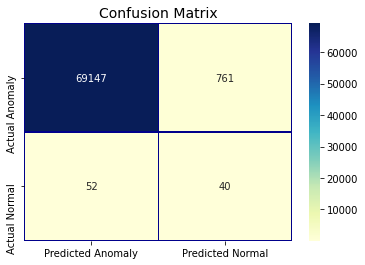

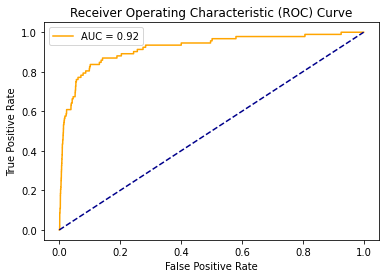

In [ ]:
get_prediction(HBOS(n_bins=100, alpha=0.1, tol=0.5, contamination=0.05), train_X,
               test_X, train_y, test_y, model_name = 'HBOS')


On Training Data:
HBOS ROC:0.9718, precision @ rank n:0.8771

On Test Data:
HBOS ROC:0.9122, precision @ rank n:0.0326

 HBOS  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.02      0.02      0.02        92

    accuracy                           1.00     70000
   macro avg       0.51      0.51      0.51     70000
weighted avg       1.00      1.00      1.00     70000


 HBOS Matthews Correlation Coefficient 0.021962193472378228

 HBOS f1-score 0.023121387283236997


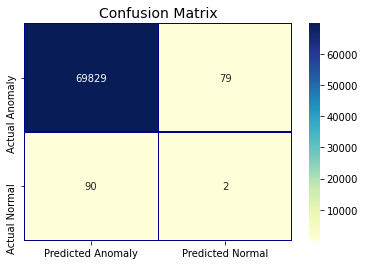

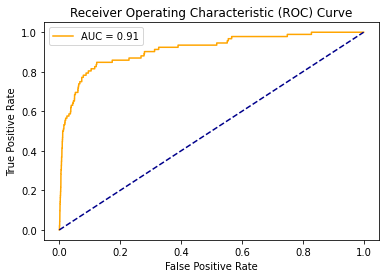

In [ ]:
get_prediction(HBOS(n_bins=80, alpha=0.1, tol=0.5, contamination=0.01), train_X_std,
               test_X_std, train_y_std, test_y, model_name = 'HBOS')


# Results of F1 tuning

## IForest

---



On Training Data:
IForest ROC:0.8406, precision @ rank n:0.7659

On Test Data:
IForest ROC:0.8443, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     69908
     Anomaly       0.00      0.01      0.00        92

    accuracy                           0.99     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      0.99      0.99     70000


 IForest Matthews Correlation Coefficient 0.0015060632674165405

 IForest f1-score 0.0033057851239669416


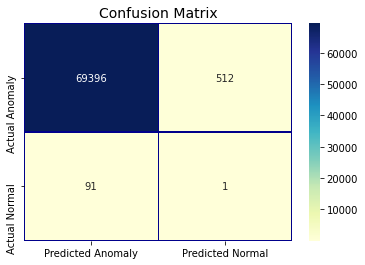

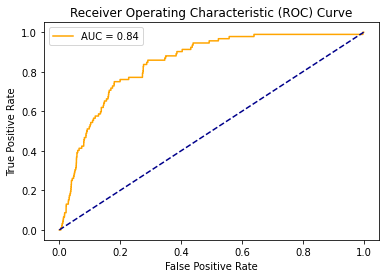

In [ ]:
#Oversampled
#Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 256, contamination = 0.07), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.823, precision @ rank n:0.7433

On Test Data:
IForest ROC:0.776, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     69908
     Anomaly       0.00      0.02      0.01        92

    accuracy                           0.99     70000
   macro avg       0.50      0.51      0.50     70000
weighted avg       1.00      0.99      0.99     70000


 IForest Matthews Correlation Coefficient 0.0043131004223263235

 IForest f1-score 0.005076142131979695


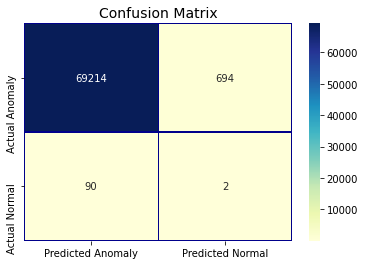

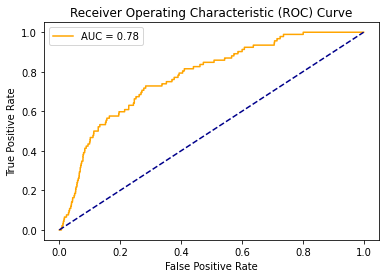

In [ ]:
#Oversampled
#Not standardized
get_prediction(IForest(n_estimators = 125, max_samples = 'auto', contamination = 0.09), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.9438, precision @ rank n:0.7106

On Test Data:
IForest ROC:0.906, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     69908
     Anomaly       0.02      0.43      0.05        92

    accuracy                           0.98     70000
   macro avg       0.51      0.71      0.52     70000
weighted avg       1.00      0.98      0.99     70000


 IForest Matthews Correlation Coefficient 0.09768494248331587

 IForest f1-score 0.045402951191827474


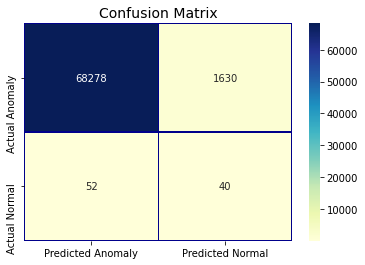

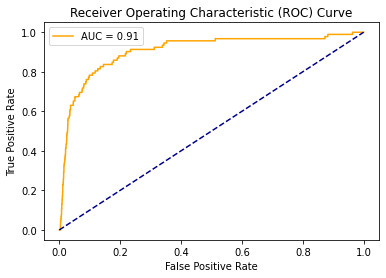

In [ ]:
#Not oversampled
#Not standardized
get_prediction(IForest(n_estimators = 125, max_samples = 'auto', contamination = 0.05), 
               train_X, test_X, train_y, test_y, 'IForest')

On Training Data:
IForest ROC:0.9435, precision @ rank n:0.6963

On Test Data:
IForest ROC:0.9278, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     69908
     Anomaly       0.03      0.64      0.06        92

    accuracy                           0.97     70000
   macro avg       0.52      0.81      0.52     70000
weighted avg       1.00      0.97      0.98     70000


 IForest Matthews Correlation Coefficient 0.13589787281544763

 IForest f1-score 0.058300395256917


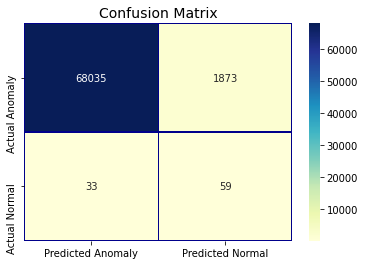

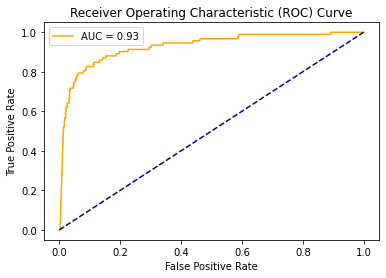

In [ ]:
#Not oversampled
#Standardized
get_prediction(IForest(n_estimators = 50 , max_samples = 'auto', contamination = 0.07), 
               train_X_std, test_X_std, train_y_std, test_y, 'IForest')

##OCSVM

---



In [ ]:
#Not Oversampled
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.622, precision @ rank n:0.0489

On Test Data:


In [ ]:
#oversampled- Adasyn
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_ada, test_X, train_y_ada, test_y, 'OCSVM')

## HBOS (Not included in the experiments)
---

On Training Data:
LOF ROC:0.5497, precision @ rank n:0.5176

On Test Data:
LOF ROC:0.4402, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 LOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 LOF f1-score 0.0026251212691890654


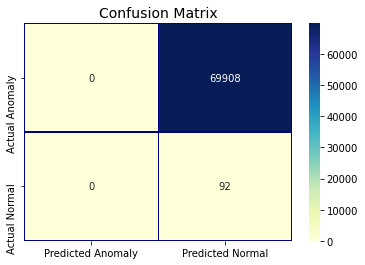

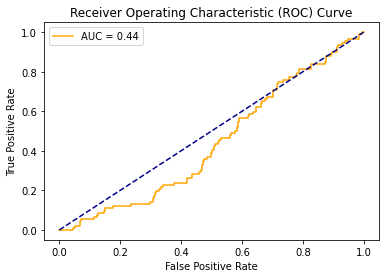

In [ ]:
#oversampled
#standardized
get_prediction(HBOS(n_neighbors=100, contamination= 0.07, algorithm='auto', metric= 'l2'), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.469, precision @ rank n:0.4733

On Test Data:
LOF ROC:0.4402, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 LOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 LOF f1-score 0.0026251212691890654


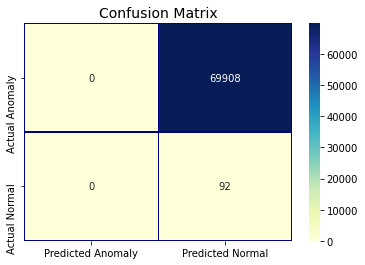

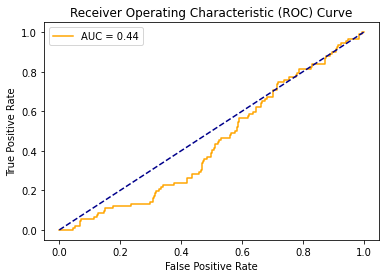

In [ ]:
#oversampled
#not standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.09, algorithm='auto', metric= 'euclidean'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.8413, precision @ rank n:0.31

On Test Data:
LOF ROC:0.9131, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.03      0.08      0.04        92

    accuracy                           1.00     70000
   macro avg       0.51      0.54      0.52     70000
weighted avg       1.00      1.00      1.00     70000


 LOF Matthews Correlation Coefficient 0.043435351681079974

 LOF f1-score 0.04011461318051576


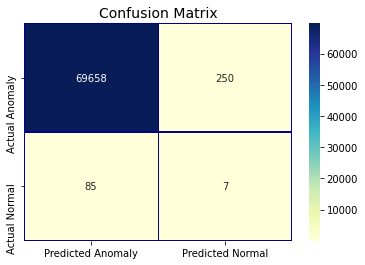

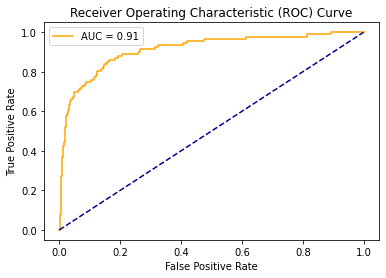

In [ ]:
#not oversampled
#not standardized
get_prediction(LOF(n_neighbors=500, contamination= 0.07, algorithm='auto', metric= 'cosine'), 
               train_X, test_X, train_y, test_y, 'LOF')

On Training Data:
LOF ROC:0.8103, precision @ rank n:0.5166

On Test Data:
LOF ROC:0.4405, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 LOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 LOF f1-score 0.0026251212691890654


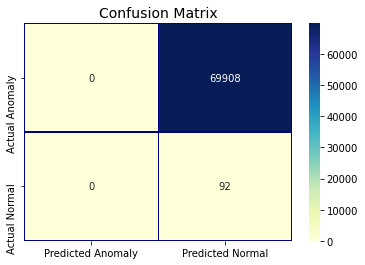

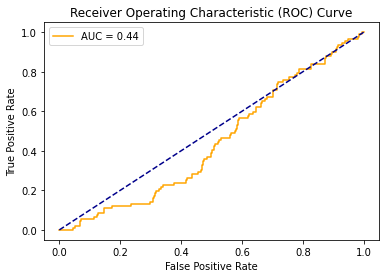

In [ ]:
#not oversampled
#standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.03, algorithm='auto', metric= 'l1'), 
               train_X_std, test_X_std, train_y_std, test_y, 'LOF')

## LOF

---



On Training Data:
LOF ROC:0.5497, precision @ rank n:0.5176

On Test Data:
LOF ROC:0.4402, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 LOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 LOF f1-score 0.0026251212691890654


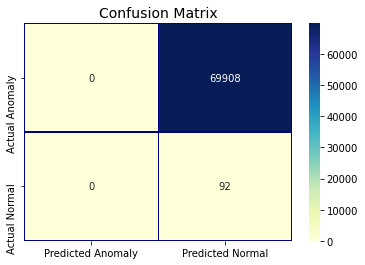

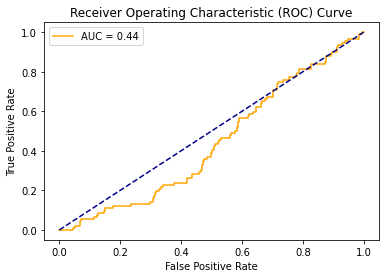

In [ ]:
#oversampled
#standardized
get_prediction(LOF(n_neighbors=100, contamination= 0.07, algorithm='auto', metric= 'l2'), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.469, precision @ rank n:0.4733

On Test Data:
LOF ROC:0.4402, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 LOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 LOF f1-score 0.0026251212691890654


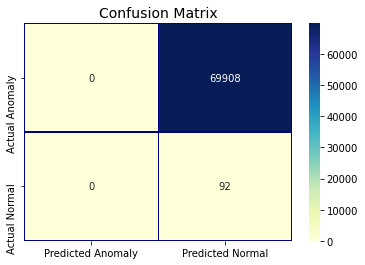

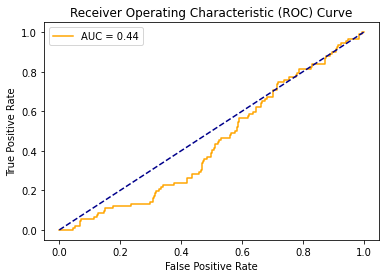

In [ ]:
#oversampled
#not standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.09, algorithm='auto', metric= 'euclidean'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.8413, precision @ rank n:0.31

On Test Data:
LOF ROC:0.9131, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     69908
     Anomaly       0.03      0.08      0.04        92

    accuracy                           1.00     70000
   macro avg       0.51      0.54      0.52     70000
weighted avg       1.00      1.00      1.00     70000


 LOF Matthews Correlation Coefficient 0.043435351681079974

 LOF f1-score 0.04011461318051576


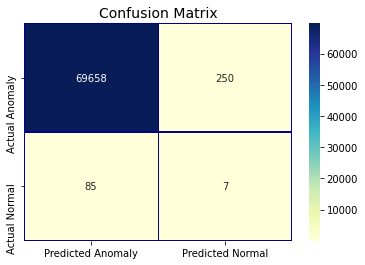

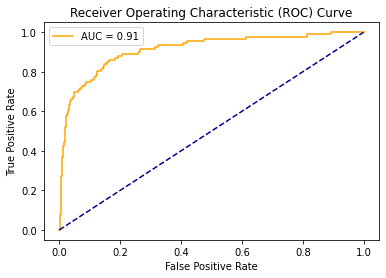

In [ ]:
#not oversampled
#not standardized
get_prediction(LOF(n_neighbors=500, contamination= 0.07, algorithm='auto', metric= 'cosine'), 
               train_X, test_X, train_y, test_y, 'LOF')

On Training Data:
LOF ROC:0.8103, precision @ rank n:0.5166

On Test Data:
LOF ROC:0.4405, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 LOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 LOF f1-score 0.0026251212691890654


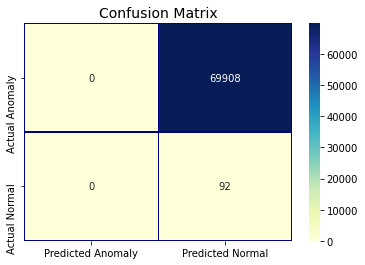

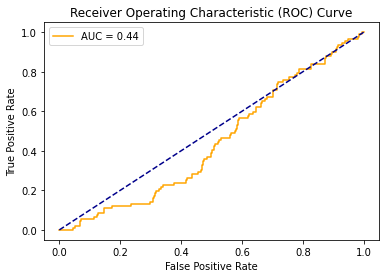

In [ ]:
#not oversampled
#standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.03, algorithm='auto', metric= 'l1'), 
               train_X_std, test_X_std, train_y_std, test_y, 'LOF')

## CBLOF

---



On Training Data:
CBLOF ROC:0.555, precision @ rank n:0.5193

On Test Data:
CBLOF ROC:0.4402, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 CBLOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 CBLOF f1-score 0.0026251212691890654


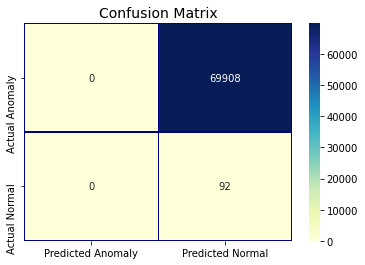

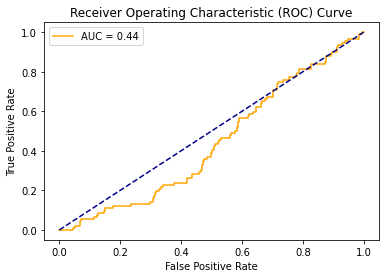

In [ ]:
#Oversampled
#standardized
get_prediction(CBLOF(contamination= 0.07, n_clusters= 25, alpha= 0.8, beta= 20, random_state= 42), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.4906, precision @ rank n:0.4737

On Test Data:
CBLOF ROC:0.4402, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.21      0.35     69908
     Anomaly       0.00      0.79      0.00        92

    accuracy                           0.21     70000
   macro avg       0.50      0.50      0.18     70000
weighted avg       1.00      0.21      0.35     70000


 CBLOF Matthews Correlation Coefficient 0.0005815091079820249

 CBLOF f1-score 0.0026460780049296796


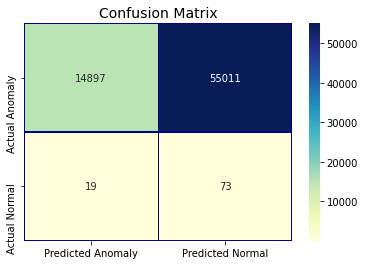

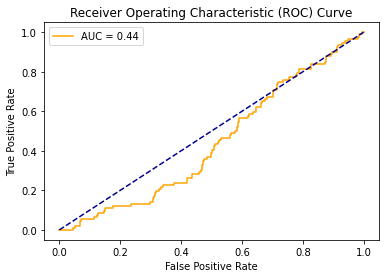

In [ ]:
#oversampled
#not standardized
get_prediction(CBLOF(contamination= 0.09, n_clusters= 25, alpha= 0.8, beta= 25, use_weights=True, random_state= 42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.6366, precision @ rank n:0.1961

On Test Data:
CBLOF ROC:0.4402, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 CBLOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 CBLOF f1-score 0.0026251212691890654


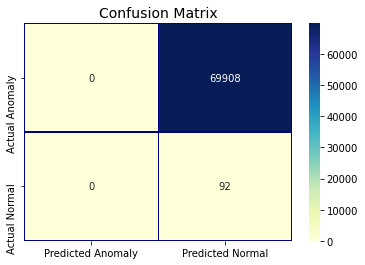

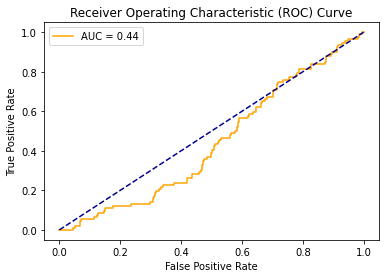

In [ ]:
#not oversampled
#not standardized
get_prediction(CBLOF(contamination= 0.09, n_clusters= 25, alpha= 0.8, beta= 20, use_weights=True, random_state= 42), 
               train_X, test_X, train_y, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.6621, precision @ rank n:0.2597

On Test Data:
CBLOF ROC:0.4402, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 CBLOF Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 CBLOF f1-score 0.0026251212691890654


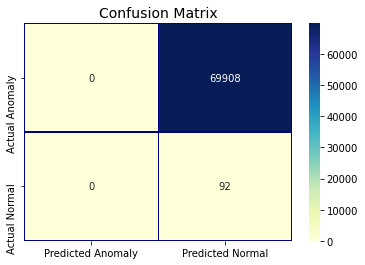

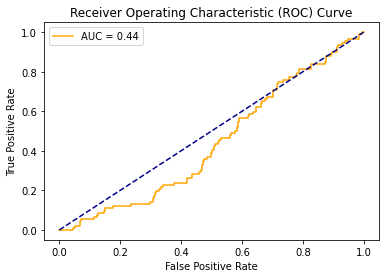

In [ ]:
#not oversampled
#standardized
get_prediction(CBLOF(contamination= 0.07, n_clusters= 25, alpha= 0.8, beta= 15, use_weights=True, random_state= 42), 
               train_X_std, test_X_std, train_y_std, test_y, 'CBLOF')

## KNN

---



On Training Data:
KNN ROC:0.4555, precision @ rank n:0.479

On Test Data:
KNN ROC:0.4402, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 KNN Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 KNN f1-score 0.0026251212691890654


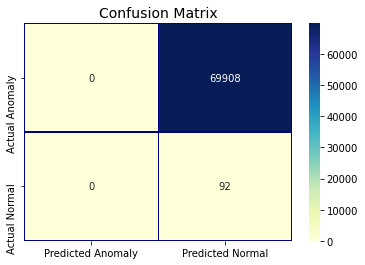

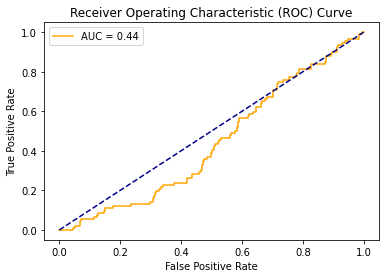

In [ ]:
#Oversampled 
#Standardized
get_prediction(KNN(n_neighbors= 100, method= 'mean', algorithm='auto',contamination= 0.05), 
               train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.3172, precision @ rank n:0.378

On Test Data:
KNN ROC:0.4401, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 KNN Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 KNN f1-score 0.0026251212691890654


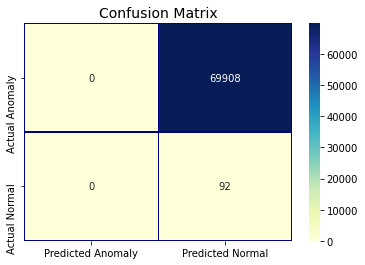

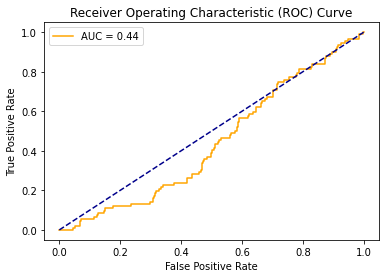

In [ ]:
#Oversampled
#Not Standardized
get_prediction(KNN(n_neighbors= 20, method= 'median', algorithm='auto',contamination= 0.03), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.7761, precision @ rank n:0.3483

On Test Data:
KNN ROC:0.4402, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 KNN Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 KNN f1-score 0.0026251212691890654


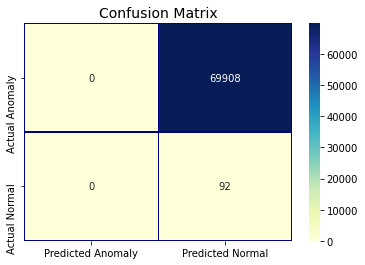

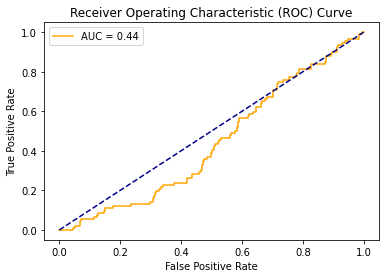

In [ ]:
#Not oversampled
#Not standardşzed
get_prediction(KNN(n_neighbors= 100, method= 'mean', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

On Training Data:
KNN ROC:0.7157, precision @ rank n:0.5146

On Test Data:
KNN ROC:0.4402, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     69908
     Anomaly       0.00      1.00      0.00        92

    accuracy                           0.00     70000
   macro avg       0.00      0.50      0.00     70000
weighted avg       0.00      0.00      0.00     70000


 KNN Matthews Correlation Coefficient 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



 KNN f1-score 0.0026251212691890654


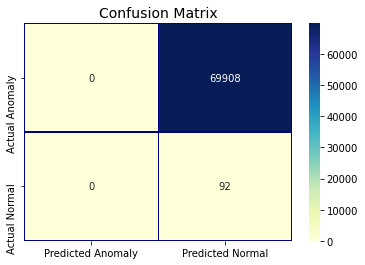

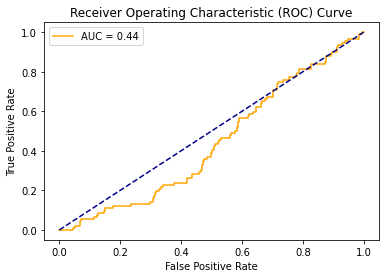

In [ ]:
#Not oversampled
#Standardized (n = 5)
get_prediction(KNN(n_neighbors= 5, method= 'mean', algorithm='auto',contamination= 0.01), 
               train_X_std, test_X_std, train_y_std, test_y, 'KNN')

## SCiForest-Isotree

---



In [ ]:
#Oversampled
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X_std_resampled, test_X_std, train_y_std_resampled, test_y, 'IForest')

In [ ]:
#Oversampled
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

In [ ]:
#Not Oversampled
#not standardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

In [ ]:
#Not Oversampled
#standardized
get_prediction_iso(IsolationForest(sample_size = , ndim=2, ntrees=, penalize_range=False, missing_action = "fail"), 
                   train_X_std, test_X_std, train_y_std, test_y, 'IForest')